In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sys
import os
import minepy

import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import scipy.spatial.distance as ssd

from PIL import Image
from collections import defaultdict
from decimal import Decimal
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette, linkage
from matplotlib.colors import rgb2hex, colorConverter
sns.set_style("white")
# sns.set(color_codes=True)
%matplotlib inline
os.chdir("/Users/KevinBu/Desktop/Clemente Lab/imageproc/")

In [10]:
df = pd.read_csv('data/anscombes.txt', sep = '\t')
print len(df)
df.head()

44


,x,y,group
0,10,8.04,A
1,8,6.95,A
2,13,7.58,A
3,9,8.81,A
4,11,8.33,A


In [11]:
n_sim = 10
np.random.seed(0)
mu, sigma = 0, 0.1 

# key 1 is the group, key 2 is the simulation number
sim_plots = dict()
for i in df.group:
    sim_plots[i] = dict()
    rel_df = df[df['group'] == i].drop('group', axis = 1)
    for j in range(n_sim):
        sim_plots[i][j] = rel_df + np.random.normal(mu, sigma, [len(rel_df),len(rel_df.columns)])

print 'Done'

Done


In [12]:
try:
    os.makedirs('data/aq10x/')
    os.makedirs('data/aq10x/spearman')
    os.makedirs('data/aq10x/pearson')
    os.makedirs('data/aq10x/kendall')
    os.makedirs('data/aq10x/MIC')
except:
    pass

# for each type in 'dataset'
#  plot them
for class_name in df['group']:
    # obtain relevant data
    current_set = sim_plots[class_name]
    for plot in current_set:
        current_df = current_set[plot]
        # create figure
        fig = plt.figure()
        sns_plot = sns.lmplot('x', 'y', data = current_df, fit_reg = False, palette = "Set1")
        sc, sp = scipy.stats.spearmanr(current_df['x'], current_df['y'])
        pc, pp = scipy.stats.pearsonr(current_df['x'], current_df['y'])
        kc, kp = scipy.stats.kendalltau(current_df['x'], current_df['y'])
        MIC = minepy.pstats(current_df.T, alpha=0.6, c=15, est="mic_approx")[0][0]
        ax = plt.gca()
        ax.set_position(np.array([.1,.1,.8,.8]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False,
            labelleft=False)
        plt.ticklabel_format(useOffset=False, style='plain', axis='both')
        ax.set_ylabel('')    
        ax.set_xlabel('')
        fig.patch.set_visible(False)
        ax.patch.set_visible(False)
        plt.savefig('data/aq10x/spearman/' + class_name + '_' + str(plot) + '_' + str(round(sc, 3)) + '.JPG') 
        plt.savefig('data/aq10x/pearson/' + class_name + '_' + str(plot) + '_' + str(round(pc, 3)) + '.JPG')
        plt.savefig('data/aq10x/kendall/' + class_name + '_' + str(plot) + '_' + str(round(kc, 3))  + '.JPG')    
        plt.savefig('data/aq10x/mic/' + class_name + '_' + str(plot) + '_' +  str(round(MIC, 3))  + '.JPG')
        plt.close()
        
print 'Done'

0.5046837039013502 0.01425038073289891 2
0.5046837039013502 0.01425038073289891 2
0.5046837039013502 0.01425038073289891 2
0.5293347286123048 0.013527518631333883 3
0.560377976800401 0.014894654443220495 4
0.560377976800401 0.014894654443220495 4
0.5832104260128894 0.04407956785126883 5
0.5832104260128894 0.04407956785126883 5
0.6273401258454668 0.09543182991499424 7
0.6678907713188414 0.17258971720687166 9


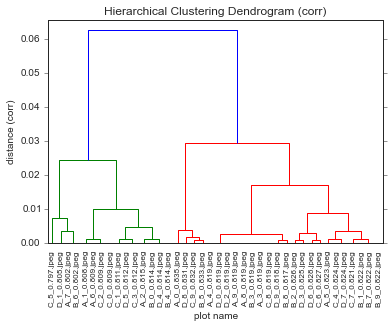

In [138]:
# corr
from sklearn.metrics import v_measure_score

path = 'data/aq10x_postanalysis/pearson/'

df = pd.read_csv(path + 'corr.txt', sep = '\t')
names = df.columns.values
true_names = [x.split('_')[0] for x in names]

# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(df.values)

# Calculate the distance between each sample
Z = linkage(distArray, 'ward')
 
# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram (corr)')
plt.xlabel('plot name')
plt.ylabel('distance (corr)') # or corr
R = dendrogram(Z, labels=names, leaf_rotation=90)

for sim in np.arange(0,1,0.1):
    cut = hierarchy.fcluster(Z, t=distArray.max()*(1.0-sim), criterion='distance')
    cluster_dct = dict((ii,[]) for ii in np.unique(cut))
    for iimg,iclus in enumerate(cut):
        cluster_dct[iclus].append(names[iimg])

    clusters = list(cluster_dct.values())
    
    truth = dict()
    for i in range(len(clusters)):
        for item in clusters[i]:
            # name = item.split('/')[2].split('_')[0]
            truth[item] = i
    
    #cluster_df = pd.read_csv('data/cluster_array.txt', sep = '\t', header = None)
    #cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
    
    labels = []
    for item in names:
        labels.append(truth[item])
    
    if len(np.unique(labels)) > 1:
        results = silhouette_score(df.values, labels, metric='euclidean')
    else:
        results = 'only 1 label at ' + str(sim)
        
    print results, v_measure_score(true_names, labels), len(clusters)

#R['ivl']
#for img in R['ivl']:
image_list = [path + x for x in R['ivl']]


images = map(Image.open, image_list)
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(path + 'corr_order.jpg')

0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.3828803128426475 0.866906739901951 7
0.22790884670105688 0.7940720701134413 9
0.22790884670105688 0.7940720701134413 9
0.22790884670105688 0.7940720701134413 9
0.22790884670105688 0.7940720701134413 9
0.2255353657459207 0.7789937316080335 10
0.2255353657459

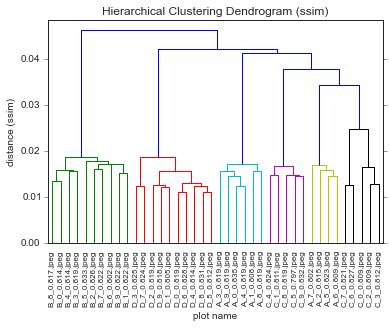

In [144]:
path = 'data/aq10x_postanalysis/pearson/'

# mse
df = pd.read_csv(path + 'ssim.txt', sep = '\t')
names = df.columns.values
true_names = [x.split('_')[0] for x in names]

# convert the redundant n*n square matrix form into a condensed nC2 array
# distArray = ssd.squareform(df.values)
distArray = ssd.squareform(1 - df.values)

# Calculate the distance between each sample
Z = linkage(distArray, 'ward')
 
# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram (ssim)')
plt.xlabel('plot name')
plt.ylabel('distance (ssim)') # or corr
R = dendrogram(Z, labels=names, leaf_rotation=90)

for sim in np.arange(0,1,0.01):
    cut = hierarchy.fcluster(Z, t=distArray.max()*(1.0-sim), criterion='distance')
    cluster_dct = dict((ii,[]) for ii in np.unique(cut))
    for iimg,iclus in enumerate(cut):
        cluster_dct[iclus].append(names[iimg])

    clusters = list(cluster_dct.values())
    
    truth = dict()
    for i in range(len(clusters)):
        for item in clusters[i]:
            # name = item.split('/')[2].split('_')[0]
            truth[item] = i
    
    #cluster_df = pd.read_csv('data/cluster_array.txt', sep = '\t', header = None)
    #cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
    
    labels = []
    for item in names:
        labels.append(truth[item])
    try:
        results = silhouette_score((1-df.values), labels, metric='euclidean')
    except:
        results = 'invalid n labels of ' + str(len(np.unique(labels))) + ' at ' + str(sim)
        
    print results, v_measure_score(true_names, labels), len(clusters)
#R['ivl']
#for img in R['ivl']:
image_list = [path + x for x in R['ivl']]

images = map(Image.open, image_list)
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(path + 'ssim_order.jpg')

0.23920929326142773 0.8342738908252932 8
0.23920929326142773 0.8342738908252932 8
0.23920929326142773 0.8342738908252932 8
0.21669035783590865 0.8089651955296641 9
0.17509071942139118 0.7700321214251147 10
0.16453519302919015 0.7414838040917576 11
0.16453519302919015 0.7414838040917576 11
0.16453519302919015 0.7414838040917576 11
0.16453519302919015 0.7414838040917576 11
0.16453519302919015 0.7414838040917576 11


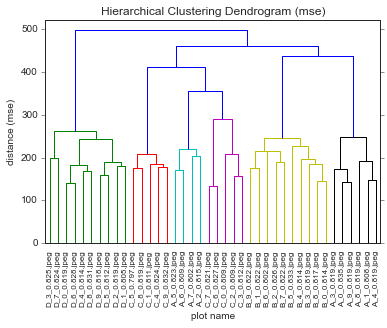

In [142]:
path = 'data/aq10x_postanalysis/pearson/'

# mse
df = pd.read_csv(path + 'mse.txt', sep = '\t')
names = df.columns.values
true_names = [x.split('_')[0] for x in names]
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(df.values)
# distArray = ssd.squareform(1 - df.values)

# Calculate the distance between each sample
Z = linkage(distArray, 'ward')
 
# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram (mse)')
plt.xlabel('plot name')
plt.ylabel('distance (mse)') # or corr
R = dendrogram(Z, labels=names, leaf_rotation=90)

for sim in np.arange(0,.1,0.01):
    cut = hierarchy.fcluster(Z, t=distArray.max()*(1.0-sim), criterion='distance')
    cluster_dct = dict((ii,[]) for ii in np.unique(cut))
    for iimg,iclus in enumerate(cut):
        cluster_dct[iclus].append(names[iimg])

    clusters = list(cluster_dct.values())
    
    truth = dict()
    for i in range(len(clusters)):
        for item in clusters[i]:
            # name = item.split('/')[2].split('_')[0]
            truth[item] = i
    
    #cluster_df = pd.read_csv('data/cluster_array.txt', sep = '\t', header = None)
    #cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
    
    labels = []
    for item in names:
        labels.append(truth[item])
    try:
        results = silhouette_score((1-df.values), labels, metric='euclidean')
    except:
        results = 'invalid n labels of ' + str(len(np.unique(labels))) + ' at ' + str(sim)
        
    print results, v_measure_score(true_names, labels), len(clusters)
#R['ivl']
#for img in R['ivl']:
image_list = [path + x for x in R['ivl']]

images = map(Image.open, image_list)
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(path + 'mse.jpg')

/Users/KevinBu/Desktop/Clemente Lab/imageproc


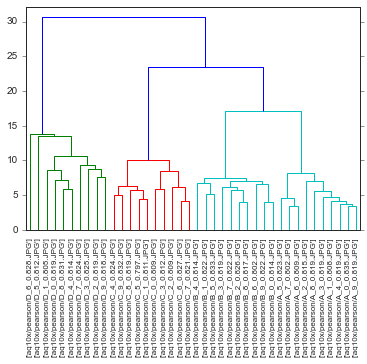

In [140]:
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
import pandas as pd

dfps_df = pd.read_csv('data/dfps.txt', sep = '\t', header = None).drop(0) # first row is junk

cond = dfps_df.iloc[:,1:].values.flatten()
sq = distance.squareform(cond)

cluster_df = pd.read_csv('data/cluster_array.txt', sep = '\t', header = None)
cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
true_names = cluster_df['group']

print os.getcwd()

df = pd.read_csv('data/Z.txt', sep = '\t')
Z = df.values[:,1:]

names = pd.read_csv('data/names.txt', sep = '\t')
names = names.values[:,1:]

R = dendrogram(Z, labels=names, leaf_rotation=90)

In [141]:
dfps = sq
# new_names = [x.split('/')[2].split('_')[0] for x in list(names.flatten())] 
files = list(names.flatten())
true_names = [x.split('_')[0] for x in files]
for sim in np.arange(.1,1,0.1):
    cut = hierarchy.fcluster(Z, t=dfps.max()*(1.0-sim), criterion='distance')
    cluster_dct = dict((ii,[]) for ii in np.unique(cut))
    for iimg,iclus in enumerate(cut):
        cluster_dct[iclus].append(files[iimg])

    clusters = list(cluster_dct.values())
    
    truth = dict()
    for i in range(len(clusters)):
        for item in clusters[i]:
            # name = item.split('/')[2].split('_')[0]
            truth[item] = i
    
    #cluster_df = pd.read_csv('data/cluster_array.txt', sep = '\t', header = None)
    #cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
    
    labels = []
    for item in files:
        labels.append(truth[item])
    
    if len(np.unique(labels)) > 1:
        results = silhouette_score(sq, labels, metric='euclidean')
    else:
        results = 'only 1 label at ' + str(sim)
        
    print results, v_measure_score(true_names, labels), len(clusters)


only 1 label at 0.1 6.406853007629835e-16 1
only 1 label at 0.2 6.406853007629835e-16 1
0.5830881747293712 0.5771596324111238 2
0.679549117459572 0.8571428571428574 3
0.679549117459572 0.8571428571428574 3
0.7542913565215624 1.0 4
0.6404075420878337 0.9455187322793371 6
0.399476959779297 0.7614259503950159 13
0.019535165238039536 0.5592015569037032 37


In [ ]:
# datasaurus
# comes in long form, so need to figure out how many plots and label them according to true cluster

df = pd.read_csv('data/TheDatasaurusDozen/DatasaurusDozen.tsv', sep = '\t')
try:
    os.makedirs('data/TheDatasaurusDozen/spearman')
    os.makedirs('data/TheDatasaurusDozen/pearson')
    os.makedirs('data/TheDatasaurusDozen/kendall')
    os.makedirs('data/TheDatasaurusDozen/MIC')
except:
    pass

In [ ]:
# for each type in 'dataset'
#  plot them
for class_name in df['dataset']:
    # obtain relevant data
    current_df = df[df['dataset'] == class_name]
    # create figure
    fig = plt.figure()
    sns_plot = sns.lmplot('x', 'y', data = current_df, fit_reg = False, palette = "Set1")
    sc, sp = scipy.stats.spearmanr(current_df['x'], current_df['y'])
    pc, pp = scipy.stats.pearsonr(current_df['x'], current_df['y'])
    kc, kp = scipy.stats.kendalltau(current_df['x'], current_df['y'])
    MIC = minepy.pstats(current_df.drop('dataset', axis = 1).T, alpha=0.6, c=15, est="mic_approx")[0][0]
    ax = plt.gca()
    ax.set_position(np.array([.1,.1,.8,.8]))
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False,
        labelleft=False)
    plt.ticklabel_format(useOffset=False, style='plain', axis='both')
    ax.set_ylabel('')    
    ax.set_xlabel('')
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig('data/TheDatasaurusDozen/spearman/' + class_name + '_' + str(round(sc, 3)) + '.jpeg') 
    plt.savefig('data/TheDatasaurusDozen/pearson/' + class_name + '_' + str(round(pc, 3)) + '.jpeg')
    plt.savefig('data/TheDatasaurusDozen/kendall/' + class_name + '_' + str(round(kc, 3))  + '.jpeg')    
    plt.savefig('data/TheDatasaurusDozen/mic/' + class_name + '_' + str(round(MIC, 3))  + '.jpeg')
    plt.close()
# run image corr and try hclust on pearson, spearman, mic and finally sse

In [ ]:
path = 'data/TheDatasaurusDozen/spearman/'

# mse
df = pd.read_csv(path + 'ssim.txt', sep = '\t')
names = df.columns.values

# convert the redundant n*n square matrix form into a condensed nC2 array
# distArray = ssd.squareform(df.values)
distArray = ssd.squareform(1 - df.values)

# Calculate the distance between each sample
Z = linkage(distArray, 'ward')
 
# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram (ssim)')
plt.xlabel('plot name')
plt.ylabel('distance (ssim)') # or corr
R = dendrogram(Z, labels=names, leaf_rotation=90)

#R['ivl']
#for img in R['ivl']:
image_list = [path + x for x in R['ivl']]

images = map(Image.open, image_list)
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(path + 'ssim_order.jpg')

In [ ]:
# corr
path = 'data/TheDatasaurusDozen/spearman/'

df = pd.read_csv(path + 'corr.txt', sep = '\t')
names = df.columns.values
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(df.values)

# Calculate the distance between each sample
Z = linkage(distArray, 'ward')
 
# Make the dendrogram
plt.title('Hierarchical Clustering Dendrogram (corr)')
plt.xlabel('plot name')
plt.ylabel('distance (corr)') # or corr
R = dendrogram(Z, labels=names, leaf_rotation=90)

#R['ivl']
#for img in R['ivl']:
image_list = [path + x for x in R['ivl']]


images = map(Image.open, image_list)
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(path + 'corr_order.jpg')

In [ ]:

# We also set some prettier non-default colours.

sns.set_palette('Set1', 10, 0.65)
palette = sns.color_palette()
set_link_color_palette(map(rgb2hex, palette))
sns.set_style('white')

cluster_idxs = defaultdict(list)
for c, pi in zip(R['color_list'], R['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

# cluster_idxs
# defaultdict(<type 'list'>, {'#c13d3f': [1, 2], '#AAAAAA': [0]})

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
    
cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [R['ivl'][i] for i in l]
    cluster_classes[c] = i_l

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

get_cluster_classes(R)
from scipy.cluster.hierarchy import fcluster
k = 3
cluster_numbers = fcluster(Z, k, criterion='maxclust')
n_samp = len(cluster_numbers)
cluster_to_image = defaultdict(list)
for x in range(n_samp):
    c = cluster_numbers[x]
    cluster_to_image[c].append(names[x])
print cluster_to_image
    


In [ ]:
# generating data from WHO
df = pd.read_csv("/Users/KevinBu/Desktop/Clemente Lab/CUtIe/data_analysis/" + 
                 "cutie_WHO_ksc1fdr0.05/data_processing/R_matrix_L6_resample_1.txt", sep = "\t")
df = df.loc[df['var1_index'] > df['var2_index']]

WHO_small_df = df[(df['correlations'] > 0.1995) & (df['correlations'] < 0.2005)]
WHO_medium_df = df[(df['correlations'] > 0.4995) & (df['correlations'] < 0.5005)] # for spearman
# WHO_medium_df = df[(df['correlations'] > 0.499) & (df['correlations'] < 0.501)] # for pearson
WHO_large_df = df[(df['correlations'] > 0.8975) & (df['correlations'] < 0.9025)]

print len(WHO_small_df)
print len(WHO_medium_df)
print len(WHO_large_df)

In [ ]:
df_list = [WHO_small_df, WHO_medium_df, WHO_large_df]
dir_list = ['data/WHO_ksc_plots/small/', 'data/WHO_ksc_plots/medium/', 'data/WHO_ksc_plots/large/']
# dir_list = ['data/WHO_kpc_plots/small/', 'data/WHO_kpc_plots/medium/', 'data/WHO_kpc_plots/large/']
# df_list = [WHO_small_df] #, WHO_medium_df, WHO_large_df]
# dir_list = ['data/WHO_ksc_plots/small/'] # , 'data/WHO_ksc_plots/medium/', 'data/WHO_ksc_plots/large/']

In [ ]:
data = pd.read_csv('/Users/KevinBu/Desktop/Clemente Lab/CUtIe/data/MINE/WHOfix.txt', sep = '\t')
xnames = data.columns.values[3:]
plotting_data = pd.read_csv('/Users/KevinBu/Desktop/Clemente Lab/CUtIe/data/MINE/WHOfix.txt', sep = '\t')
plotting_data.columns = [str(x) for x in range(len(plotting_data.columns))]
plotting_xnames = plotting_data.columns.values[3:]
print 'Done'

In [ ]:
font = {'size'   : 2}

matplotlib.rc('font', **font)
try:
    os.makedirs('data/WHO_kpc_plots')
    os.makedirs('data/WHO_kpc_plots/small/')
    os.makedirs('data/WHO_kpc_plots/medium/')
    os.makedirs('data/WHO_kpc_plots/large/')
except:
    pass
try:
    os.makedirs('data/WHO_ksc_plots')
    os.makedirs('data/WHO_ksc_plots/small/')
    os.makedirs('data/WHO_ksc_plots/medium/')
    os.makedirs('data/WHO_ksc_plots/large/')
except:
    pass
# for each type in 'dataset'
#  plot them
for i in range(len(df_list)):
    df = df_list[i]
    for index, row in df.iterrows():
        var1 = int(row['var1_index'])
        var2 = int(row['var2_index'])
        current_data = plotting_data[[plotting_xnames[var1], plotting_xnames[var2]]].dropna()
                
        # create figure
        fig = plt.figure()

        sns_plot = sns.lmplot(plotting_xnames[var1], plotting_xnames[var2], data = current_data, 
                              fit_reg = False, palette = "Set1")
        #sc, sp = scipy.stats.spearmanr(current_df['x'], current_df['y'])
        #pc, pp = scipy.stats.pearsonr(current_df['x'], current_df['y'])
        #kc, kp = scipy.stats.kendalltau(current_df['x'], current_df['y'])
        #MIC = minepy.pstats(current_df.drop('dataset', axis = 1).T, alpha=0.6, c=15, est="mic_approx")[0][0]
        ax = plt.gca()
        ax.set_position(np.array([.1,.1,.8,.8]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                        labelbottom=False, labelleft=False)
        ax.set_ylabel('')    
        ax.set_xlabel('')
        ax.set_title('')
        # plt.figure(figsize=(3,3))
        plt.ticklabel_format(useOffset=False, style='plain', axis='both')
        fig.patch.set_visible(False)
        ax.patch.set_visible(False)
        plt.savefig(dir_list[i] + 'WHO_' + str(var1) + '_' + str(var2) + '_' + \
                    str(round(float(row['correlations']),2)) + '.jpeg')
        #plt.savefig('data/TheDatasaurusDozen/spearman/' + class_name + '_' + str(round(sc, 3)) + '.jpeg') 
        #plt.savefig('data/TheDatasaurusDozen/pearson/' + class_name + '_' + str(round(pc, 3)) + '.jpeg')
        #plt.savefig('data/TheDatasaurusDozen/kendall/' + class_name + '_' + str(round(kc, 3))  + '.jpeg')    
        #plt.savefig('data/TheDatasaurusDozen/mic/' + class_name + '_' + str(round(MIC, 3))  + '.jpeg')
        plt.close()

In [ ]:
for path in dir_list:
    # mse
    df = pd.read_csv(path + 'ssim.txt', sep = '\t')
    # df = pd.read_csv(path + 'mse.txt', sep = '\t')
    
    names = df.columns.values
    import scipy.spatial.distance as ssd
    # convert the redundant n*n square matrix form into a condensed nC2 array
    distArray = ssd.squareform(1 - df.values)
    # distArray = ssd.squareform(df.values)

    # Calculate the distance between each sample
    Z = linkage(distArray, 'ward')
    fig = plt.figure()
    # Make the dendrogram
    plt.title('Hierarchical Clustering Dendrogram (ssim)')
    plt.xlabel('plot name')
    plt.ylabel('distance (ssim)') # or corr
    R = dendrogram(Z, labels=names, leaf_rotation=90)

    image_list = [path + x for x in R['ivl']]
    images = map(Image.open, image_list)
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save(path + 'ssim_order.jpg')
    #new_im.save(path + 'ssim_order.jpg')

In [ ]:
# We also set some prettier non-default colours.
path = 'data/WHO_ksc_plots/medium/' # 'data/WHO_plots/medium', 'data/WHO_plots/large'
df = pd.read_csv(path + 'ssim.txt', sep = '\t')

names = df.columns.values
distArray = ssd.squareform(1 - df.values)
# distArray = ssd.squareform(df.values)

Z = linkage(distArray, 'ward')
R = dendrogram(Z, labels=names, leaf_rotation=90)
    
    
sns.set_palette('Set1', 10, 0.65)
palette = sns.color_palette()
set_link_color_palette(map(rgb2hex, palette))
sns.set_style('white')

cluster_idxs = defaultdict(list)
for c, pi in zip(R['color_list'], R['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

# cluster_idxs
# defaultdict(<type 'list'>, {'#c13d3f': [1, 2], '#AAAAAA': [0]})

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
    
cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [R['ivl'][i] for i in l]
    cluster_classes[c] = i_l

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

get_cluster_classes(R)

In [ ]:
from scipy.cluster.hierarchy import fcluster
k = 2
cluster_numbers = fcluster(Z, k, criterion='maxclust')
n_samp = len(cluster_numbers)
cluster_to_image = defaultdict(list)
for x in range(n_samp):
    c = cluster_numbers[x]
    cluster_to_image[c].append(names[x])

# os.chdir('/Users/KevinBu/Desktop/Clemente Lab/imageproc/data_analysis/WHO_large')
#df = pd.read_csv('/Users/KevinBu/Desktop/Clemente Lab/CUtIe/data/pre_sparcc_MSQ/otu_table.MSQ34_L6.txt', sep = '\t', skiprows=1)
#xnames = df['#OTU ID'].values[0:]
#os.chdir('/Users/KevinBu/Desktop/Clemente Lab/imageproc/data_analysis/lungc')
for key in cluster_to_image:
    cluster = key
    
    var_list = set()
    base_imlist = cluster_to_image[key]
    imlist = [path + x for x in base_imlist]
    
    # Assuming all images are the same size, get dimensions of first image
    w,h=Image.open(imlist[0]).size
    N=len(imlist)

    # Create a numpy array of floats to store the average (assume RGB images)
    arr=np.zeros((h,w,3),np.float)

    # Build up average pixel intensities, casting each image as an array of floats
    for im in imlist:
        imarr=np.array(Image.open(im),dtype=np.float)
        arr=arr+imarr/N

        var1, var2 = int(os.path.basename(im).split('_')[1]), int(os.path.basename(im).split('_')[2])
        var_list.add(xnames[var1])
        var_list.add(xnames[var2])

    # Round values in array and cast as 8-bit integer
    arr=np.array(np.round(arr),dtype=np.uint8)

    # Generate, save and preview final image
    out=Image.fromarray(arr,mode="RGB")
    out.save(path + str(cluster) + "_average.jpg")

    with open(path + str(cluster) + "_varlist.txt", 'w') as f:
        for var in var_list:
            f.write(var + '\n')

    images = map(Image.open, imlist)
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save(path + str(cluster) + '_ssim_order.jpg')

In [ ]:
imlist